In [62]:
#importing same packages as my last project
import os
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color = sns.color_palette("flare", as_cmap=True)

import keras
from keras.models import Model, Sequential
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow

#!pip install efficientnet <---installed

import efficientnet.keras as efn
from keras import regularizers 
from keras.regularizers import l2


from skimage.io import imread
from skimage.transform import resize
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

np.random.seed(21)

In [2]:
main_dir = 'benignmalignant/'
data_directory = os.listdir('benignmalignant/')
print(data_directory)

['test', 'train']


In [3]:
for _set in ['test', 'train']:
    x_benign = len(os.listdir(main_dir + _set + '/benign'))
    x_malignant = len(os.listdir(main_dir + _set + '/malignant'))
    print('Set: {}, Benign Images: {}, Malignant Images: {}, Total: {}'.format(_set, x_benign,
                                                                                x_malignant, (x_benign + x_malignant)))

Set: test, Benign Images: 360, Malignant Images: 300, Total: 660
Set: train, Benign Images: 1440, Malignant Images: 1197, Total: 2637


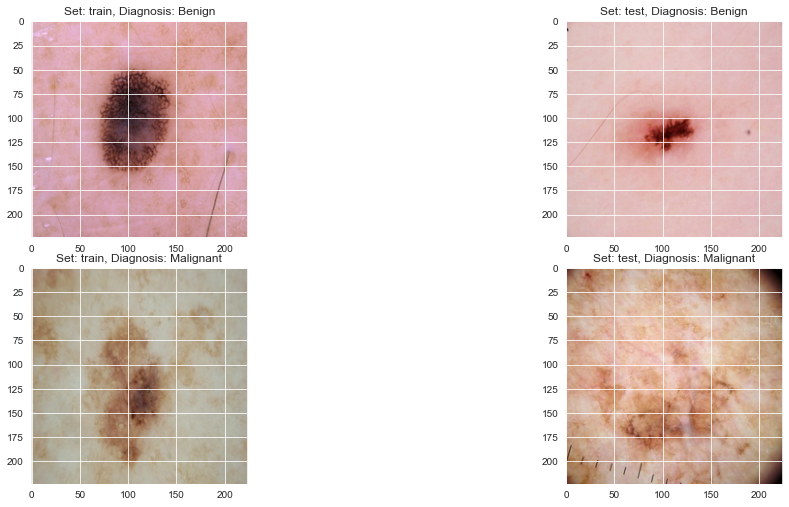

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'test']):
    set_path = main_dir+_set
    ax[i].imshow(plt.imread(set_path+'/benign/'+os.listdir(set_path+'/benign')[0]), cmap='gist_gray')
    ax[i].set_title('Set: {}, Diagnosis: Benign'.format(_set))
    ax[i+2].imshow(plt.imread(set_path+'/malignant/'+os.listdir(set_path+'/malignant')[0]), cmap='gist_gray')
    ax[i+2].set_title('Set: {}, Diagnosis: Malignant'.format(_set))

# Model 1

In [5]:
train_dir = os.path.join(main_dir, "train/")
test_dir = os.path.join(main_dir, "test/")

In [6]:
#Train data:
train_df = []

benign_set = os.path.join(train_dir,'benign')
malignant_set = os.path.join(train_dir,'malignant')

#Image list:
benign_images = glob(benign_set+"/*.jpg")
malignant_images = glob(malignant_set + "/*.jpg")

#Benign scans are labeled 0:
for img in benign_images:
    train_df.append((img, 0))

#Malignant are labeled 1:
for img in malignant_images:
    train_df.append((img, 1))

#Creating a dataframe:
train_df = pd.DataFrame(train_df, columns=['Image', 'Diagnosis'], index=None)

In [7]:
#Test data:
test_df = []

benign_set = os.path.join(test_dir,'benign')
malignant_set = os.path.join(test_dir,'malignant')

#Image list:
benign_images = glob(benign_set+"/*.jpg")
malignant_images = glob(malignant_set + "/*.jpg")

#Benign scans are labeled 0:
for img in benign_images:
    test_df.append((img, 0))

#Malignant are labeled 1:
for img in malignant_images:
    test_df.append((img, 1))

#Create the dataframe:
test_df = pd.DataFrame(test_df, columns=['Image', 'Diagnosis'], index=None)

## Plotting Binary Data:

In [8]:
def balance_check(data):
#'data': the dfs we've created
    image_count = data['Diagnosis'].value_counts()
    print('Counts:')
    print(image_count)
    
    plt.figure(figsize=(11,7))
    sns.barplot(x= image_count.index, y= image_count.values)
    plt.title('Plot of Diagnosis Balancing', fontsize= 14)
    plt.xlabel('Diagnosis', fontsize= 11)
    plt.ylabel('Image Count', fontsize= 11)
    plt.xticks(range(len(image_count.index)), ['Benign(0)', 'Malignant(1)'])
    plt.show()

Counts:
0    1440
1    1197
Name: Diagnosis, dtype: int64


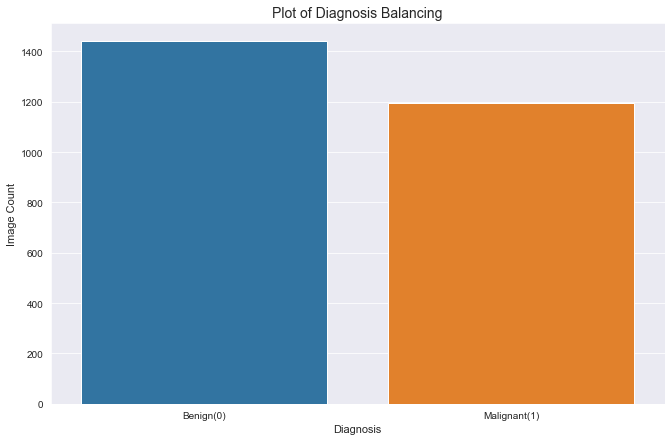

In [9]:
balance_check(train_df)

Counts:
0    360
1    300
Name: Diagnosis, dtype: int64


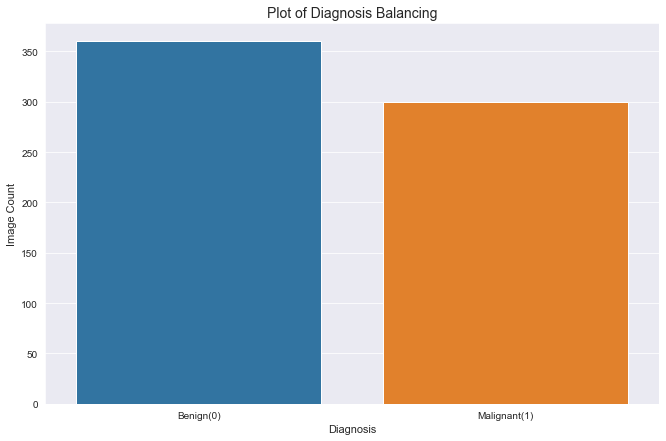

In [10]:
balance_check(test_df)

# Model 1:

## Image Augmentation

In [12]:
def data_processing(img_dims, batch_size):
    train_data_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_data_gen = ImageDataGenerator(rescale=1./255) #scaling the images to the same range [0,1]
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_generator = train_data_gen.flow_from_directory(
    directory=main_dir+'train', 
    target_size=(img_dims, img_dims),  #Each image will be resized to this size
    batch_size=batch_size, #number of observations that are inputted into the model at one time
    class_mode='binary', 
    shuffle=True)

    test_generator = test_data_gen.flow_from_directory(
    directory=main_dir+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=False)
    
    # In order to plot the Confusion Matrix, I will be making predictions off of the test set in one batch size
    test_data = []
    test_labels = []

    for cond in ['/benign/', '/malignant/']:
        for img in (os.listdir(main_dir + 'test' + cond)):
            img = plt.imread(main_dir+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/benign/':
                label = 0
            elif cond=='/malignant/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_generator, test_generator, test_data, test_labels

In [13]:
import cv2
#Values for later use:
img_dims = 150
epochs = 50
batch_size = 32
train_generator, test_generator, test_data, test_labels = data_processing(img_dims, batch_size)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


### Model Visualization Function:

In [14]:
def model_performance(history):
    
    history_dict = history.history
    train_loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']#<--'val' here is for validation, and will be from the 'test' dataset
    train_accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(8,8))
    
    #Plotting loss results:    
    epochs = range(1, len(val_loss_values) + 1) #epoch: the number of times the model will be fit on the training set.
    plot1 = sns.lineplot(ax=axis[0], x=epochs, y=train_loss_values, label='Train Loss')
    
    plot1 = sns.lineplot(ax=axis[0], x=epochs, y=val_loss_values, label='Val Loss')
    plot1.set(xlabel='Epochs', ylabel='Loss')
    plot1.axes.set_title('Model Loss', fontsize=18)
    plot1.grid(b=True, which='major', axis='y') #To show the grid lines or not
    
    plot2 = sns.lineplot(ax=axis[1], x=epochs, y=train_accuracy, label='Train Accuracy')
    plot2 = sns.lineplot(ax=axis[1], x=epochs, y=val_accuracy, label='Val Accuracy')
    plot2.set(xlabel='Epochs', ylabel='Accuracy')
    plot2.axes.set_title('Model Accuracy', fontsize=20)
    plot2.grid(b=True, which='major', axis='y')
    
    plt.tight_layout()
    plt.show()

# CNN Model

In [15]:
inputs = Input(shape=(img_dims, img_dims, 3))

#1st Convolution
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#2nd Convolution
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#3rd Convolution
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#4th Convolution
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

#5th Convolution
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fully Connected layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x) #<--Converting a real value into a interpretable probability

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
#hdf5 (Hierarchical Data Format) is to store the weights of the best performing epoch
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max') #<--Reduce learning rate 
#when the metric has stopped improving.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [16]:
hist = model.fit(train_generator, steps_per_epoch=train_generator.samples // batch_size, 
           epochs=epochs, validation_data=test_generator, shuffle=True,
           validation_steps=test_generator.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/50
82/82 [==============================] - 66s 809ms/step - loss: 0.5533 - accuracy: 0.7182 - val_loss: 0.6872 - val_accuracy: 0.5625
Epoch 2/50
82/82 [==============================] - 58s 707ms/step - loss: 0.4658 - accuracy: 0.7877 - val_loss: 0.7080 - val_accuracy: 0.5625
Epoch 3/50
82/82 [==============================] - 63s 763ms/step - loss: 0.4162 - accuracy: 0.8169 - val_loss: 0.7034 - val_accuracy: 0.4375
Epoch 4/50
82/82 [==============================] - 67s 814ms/step - loss: 0.4105 - accuracy: 0.8184 - val_loss: 0.8103 - val_accuracy: 0.5625
Epoch 5/50
82/82 [==============================] - 66s 806ms/step - loss: 0.4020 - accuracy: 0.8180 - val_loss: 0.8227 - val_accuracy: 0.5625
Epoch 6/50
82/82 [==============================] - 65s 794ms/step - loss: 0.3901 - accuracy: 0.8261 - val_loss: 0.9661 - val_accuracy: 0.5625
Epoch 7/50
82/82 [==============================] - 65s 790ms/step - loss: 0.3815 - accuracy: 0.8288 - val_loss: 0.6491 - val_accuracy: 0.6578

Epoch 40/50
82/82 [==============================] - ETA: 0s - loss: 0.3161 - accuracy: 0.8595
Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.2914016210563428e-12.
82/82 [==============================] - 71s 871ms/step - loss: 0.3161 - accuracy: 0.8595 - val_loss: 0.3085 - val_accuracy: 0.8594
Epoch 41/50
82/82 [==============================] - 67s 817ms/step - loss: 0.3090 - accuracy: 0.8614 - val_loss: 0.3085 - val_accuracy: 0.8594
Epoch 42/50
82/82 [==============================] - ETA: 0s - loss: 0.3064 - accuracy: 0.8534
Epoch 00042: ReduceLROnPlateau reducing learning rate to 3.874204993273289e-13.
82/82 [==============================] - 70s 848ms/step - loss: 0.3064 - accuracy: 0.8534 - val_loss: 0.3086 - val_accuracy: 0.8594
Epoch 43/50
82/82 [==============================] - 70s 849ms/step - loss: 0.3164 - accuracy: 0.8522 - val_loss: 0.3086 - val_accuracy: 0.8594
Epoch 44/50
82/82 [==============================] - ETA: 0s - loss: 0.3241 - accuracy: 0.8568
Ep

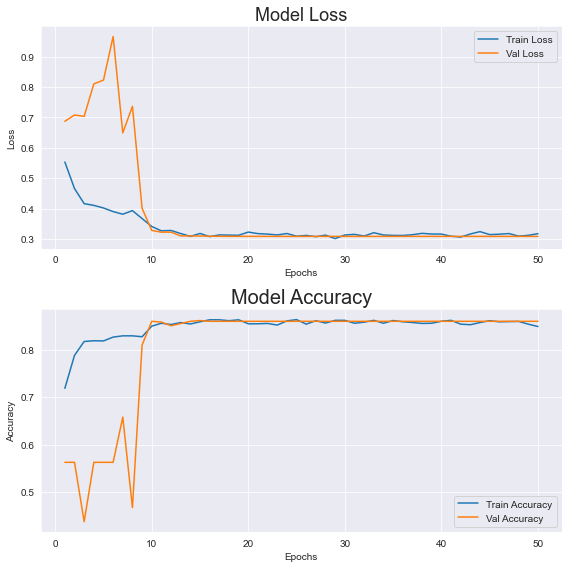

In [21]:
model_performance(hist)

In [25]:
preds = model.predict(test_generator)

accur = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()
#tp = true positive tn = true negative fp = false positive fn = false negative


print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(accur))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train Accuracy: {}'.format(np.round((hist.history["accuracy"][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[302  58]
 [ 35 265]]

TEST METRICS ----------------------
Accuracy: 85.9090909090909%
Precision: 82.04334365325077%
Recall: 88.33333333333333%
F1-score: 85.07223113964686

TRAIN METRIC ----------------------
Train Accuracy: 84.84


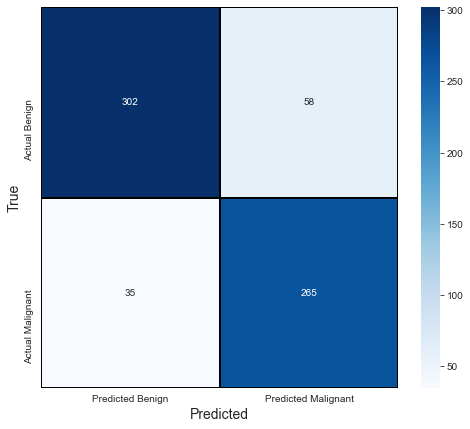

In [26]:
cm = pd.DataFrame(cm, index = ['Actual Benign', 'Actual Malignant'], columns = ['Predicted Benign', 'Predicted Malignant'])
plt.figure(figsize = (8,7))
labels = ['Benign', 'Malignant']
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1, annot = True, fmt='')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()


# Model 2:

In [84]:
def resize_images(directory, resize):
    images = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for image_name in os.listdir(directory):
        PATH = os.path.join(directory, image_name)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
            img = cv2.resize(img, (resize, resize))
            images.append(np.array(img)/255.)
    return images

In [85]:
benign_train = np.array(resize_images('benignmalignant/train/benign', 150))
malign_train = np.array(resize_images('benignmalignant/train/malignant/', 150))
benign_test = np.array(resize_images('benignmalignant/test/benign/', 150))
malign_test = np.array(resize_images('benignmalignant/test/malignant/', 150))

In [ ]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merging
x_train = np.concatenate((benign_train, malign_train), axis = 0)
y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
x_test = np.concatenate((benign_test, malign_test), axis = 0)
y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffling train data
sh = np.arange(x_train.shape[0])
np.random.shuffle(sh)
x_train = x_train[sh]
y_train = y_train[sh]

# Shuffling test data
sh = np.arange(x_test.shape[0])
np.random.shuffle(sh)
x_test = x_test[sh]
y_test = y_test[sh]


In [ ]:
# Splitting validation set from train set
x_train=x_train[500:]
x_val=x_train[:500]
y_train=y_train[500:]
y_val=y_train[:500]

In [ ]:
x_test.shape, x_val.shape, x_train.shape #<---Checking the code's success:

In [ ]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)
#y_val = to_categorical(y_val, num_classes= 2)

In [ ]:
# normalization 
x_train = x_train/255.
x_test = x_test/255.
x_val = x_val/255.

#Rechecking shape:
x_test.shape, x_val.shape, x_train.shape

In [90]:
datagen = ImageDataGenerator(rotation_range=45, zoom_range = 0.1, width_shift_range=0.2, height_shift_range=0.2, 
                             horizontal_flip=True, vertical_flip=True)

In [91]:
eff_net = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model2=Sequential()
model2.add(eff_net)
model2.add(layers.GlobalAveragePooling2D())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Dense(2, activation='softmax'))

alpha = 1e-3
for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.kernel))
    if hasattr(layer, 'bias_regularizer') and layer.use_bias:
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.bias))


model2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1280)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               163968    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512       
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 258       
Total params: 4,214,302
Trainable params: 4,172,030
Non-trainable params: 42,272
_______________________________________

In [100]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, mode='max')

checkpoint = ModelCheckpoint(filepath='best_weights2.hdf5', save_best_only=True, save_weights_only=True)

optimizer= Adam(lr=0.001)

In [102]:
model2.compile(optimizer=optimizer,loss="binary_crossentropy", metrics=['accuracy'])
hist2 = model2.fit(datagen.flow(x_train, y_train, batch_size=60), epochs=50,
                   validation_data=[x_test, y_test], callbacks=[lr_reduce, checkpoint])

Epoch 1/50
 8/83 [=>............................] - ETA: 6:31 - loss: 9.2861

KeyboardInterrupt: 